## Blender add-on

> Create add-on for blender to do mesh-creation from segmentation and pullbacks from within blender

Note: this module is _not_ for use in normal python, but must be run as an add-on in Blender.

### Notes and To do


2. axis permutation

4. better color options for vertex shading


More generally: somehow associate the data (like projections etc) to the mesh, and the image data to the bounding box, instead of having a global variable floating around. This can be done by assigning custom data as

```
obj["data_name"] = (np.array(...), shape)

```
Need to reconstruct using `np.array(arr.tolist()).reshape(shape)`.

`bpy.context.selected_objects`.

Need to be in Object mode btw.


File loading not ideal - often does not work, have to paste full path.

Idea: selected + active objects. Make sure both bounding box and mesh are selected. Give the bounding box some attribute so I know which of the selected objects is the 3d data and which is the mesh.

## Specs

### Inputs

1. Path to `.tiff` file
2. $x$/$y$/$z$ resolution (can be read out automatically)
3. Optional: path to segmentation `.tiff`

The user can also import the mesh directly. 

### Functionality

Convention: mesh vertex coordinates always have to be in microns.

0. Create bounding box (in microns) in blender that shows outline of volumetric data. Allow loading orthoslices of raw data.

1. Upon loading, convert segmentation to mesh using volume to mesh. Options: smoothing scale.

Errors: file not found, segmentation and image do not have the same number of pixels. (Q: allow separate x/y/z resolution for segmentation?)

2. Upon button click, create multilayer pullback and save to disk as pngs and multi page tiff. Also save normal and 3d coord bake. As well as max projection.

**Options**: resolution (pixels), normal layer spacing.

**Errors**: file not found, no UV map

**Warnings**: UV map has self intersections, UV map out of bounds

### Internals

1. Meshing (segmentation -> mesh). Load segmentation as .tiff, convert to vdb volume, use blenders volume to mesh node

2. Cartographic projection. The mesh used is the currently selected one! Two steps.

    a. Bake 3d coordinates and normals to UV. Use `scipy`-interpolation - render bake is difficult to get to work.

    b. Bake from volumetric data to UV. Use `scipy`-interpolation as in the pytho package.

4. Saving. Always save to fixed path, say extracted_textures in the same path as image. Careful with windows, Linux, etc path handling.

5. Create textures/shader from baked data.

6. Load orthoslices of raw data

7. Optional: Create normal shifted meshes (not visible by default). Shrink/fatten blender button.

### Conventions:

1. Mesh orientation: $Y$ forward, $Z$ up! (when importing the mesh).

### Dependencies:

1. Numpy (standard)
2. Scipy, if available (interpolation). I can also do interpolation myself 
3. `tifffile` for reading `.tiff` files (check microscopy nodes source code), and converting to .vdb (for meshing) OR some marching cubes code.


TO DO: vertex color based shading! Bounding box!

`numpy`, `scipy`, `tifffile` and `skimage` are shipped with Blender's python!

## Ressources

Add-on Tutorial: https://docs.blender.org/manual/en/latest/advanced/scripting/addon_tutorial.html

MicroscopyNodes source code: https://github.com/oanegros/MicroscopyNodes

### baking normal and world position

Texture baking the surface normals and vertex positions tunrs out to be more involved than I would like.

In particular, it is difficult to guarantee that the coordinates are not distorted or rescaled in a way that I don't understand. Also, it can be slow. Also difficult to get to work as a script, unfortunately. Often I just get black images for reasons I do not understand.

I will therefore resort to using (manual) interpolation. Luckily, it appears that `scipy` is available in blender python. We need add one extra step (UV layout mask) though,

### Experiments

In [9]:
import numpy as np
from skimage import measure
from scipy import ndimage
import tifffile

import matplotlib.pyplot as plt

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import mesh as tcmesh

In [ ]:
    channel_axis = np.argmin(image.shape) if channel_axis is None else channel_axis


In [ ]:
tifffile.

In [ ]:
data = tifffile.imread("blender_addon/Drosophila_CAAX-mCherry.tif")

In [4]:
data = tcio.read_h5("blender_addon/Drosophila_CAAX-mCherry_subsampled-image_Probabilities.h5")[0]

In [33]:
tcio.imsave("blender_addon/Drosophila_CAAX-mCherry_subsampled-image_Probabilities.tif", data)

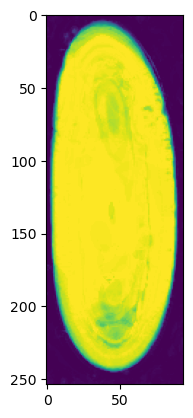

In [7]:
plt.imshow(data[50])

In [10]:
measure.marching_cubes

<function skimage.measure._marching_cubes_lewiner.marching_cubes(volume, level=None, *, spacing=(1.0, 1.0, 1.0), gradient_direction='descent', step_size=1, allow_degenerate=True, method='lewiner', mask=None)>

In [27]:
sigma = 4
resolultion = np.array([1.05, 1.05, 1.05]) * 2

verts, faces, _, _ = measure.marching_cubes(ndimage.gaussian_filter(data, sigma=sigma/resolultion)[:50],
                                            level=0.5, spacing=(1.0,1.0,1.0))
verts = verts * resolultion

In [28]:
tcmesh.ObjMesh(vertices=verts, faces=faces).write_obj("blender_addon/skimage_test_open.obj")

In [29]:
from pathlib import Path

In [32]:
Path("blender_addon/skimage_test_open.obj").stem

'skimage_test_open'

# Add-on code

In [ ]:
#| notest

bl_info = {
    "name": "Tissue Cartography",
    "blender": (3, 0, 0),
    "category": "Scene",
}

import bpy
from bpy.props import StringProperty, FloatVectorProperty, FloatProperty, IntProperty, EnumProperty
from bpy.types import Operator, Panel
from pathlib import Path
import numpy as np
import tifffile
from scipy import interpolate, ndimage
from skimage import measure

### I/O and image handling


def load_png(image_path):
    """Load .png into numpy array."""
    image = bpy.data.images.load(image_path)
    width, height = image.size
    pixels = np.array(image.pixels[:], dtype=np.float32)
    return pixels.reshape((height, width, -1))


def normalize_quantiles(image, quantiles=(0.01, 0.99), channel_axis=None, clip=False,
                        data_type=None):
    """
    Normalize a multi-dimensional image by setting given quantiles to 0 and 1.
    
    Parameters
    ----------
    image : np.array
        Multi-dimensional image.
    quantiles : tuple
        Image quantile to set to 0 and 1.
    channel_axis : int or None
        If None, the image is assumed to have only a single channel.
        If int, indicates the position of the channel axis. 
        Each channel is normalized separately.
    clip : bool
        Whether to clip image to 0-1. Automatically enabled if converting to int dtype.
    data_type : None, np.unit8 or np.uint16
        If not None, image is converted to give data type.
    
    Returns
    -------
    image_normalized : np.array
        Normalized image, the same shape as input
    """
    if channel_axis is None:
        image_normalized = image - np.nanquantile(image, quantiles[0])
        image_normalized /= np.nanquantile(image_normalized, quantiles[1])
        image_normalized = np.nan_to_num(image_normalized)
    else:
        image_normalized = np.moveaxis(image, channel_axis, 0)
        image_normalized = np.stack([ch - np.nanquantile(ch, quantiles[0]) for ch in image_normalized])
        image_normalized = np.stack([ch / np.nanquantile(ch, quantiles[1]) for ch in image_normalized])
        image_normalized = np.moveaxis(np.nan_to_num(image_normalized), 0, channel_axis)
    if clip or (data_type is not None):
        image_normalized = np.clip(image_normalized, 0, 1)
    if data_type is np.uint8:
        image_normalized = np.round((2**8-1)*image_normalized).astype(np.uint8)
    if data_type is np.uint16:
        image_normalized = np.round((2**16-1)*image_normalized).astype(np.uint16)
    return image_normalized


### Tissue cartography - projecting 3d images to UV textures


def get_uv_layout(uv_layout_path, image_resolution):
    """Get UV layout mask for currently active object and save it to disk"""
    bpy.ops.object.mode_set(mode='EDIT')
    bpy.ops.uv.export_layout(filepath=uv_layout_path, size=(image_resolution, image_resolution), opacity=1)
    bpy.ops.object.mode_set(mode='OBJECT')
    UV_layout = load_png(uv_layout_path)
    return (UV_layout.sum(axis=-1) > 0)[::-1]


def get_uv_normal_world_per_loop(mesh_obj, filter_unique=False):
    """
    Get UV, normals, and world and normal for each loop (half-edge) as np.array.
    
    If filter_unique, remove "duplicate" loops (for which UV, normals and position
    are identical).
    """
    if not mesh_obj:
        raise TypeError("No object selected")
    if mesh_obj.type != 'MESH':
        raise TypeError("Selected object is not a mesh")
    world_matrix = mesh_obj.matrix_world
    uv_layer = mesh_obj.data.uv_layers.active
    if not uv_layer:
        raise RuntimeError("Mesh does not have an active UV map")
    loop_uvs = np.zeros((len(mesh_obj.data.loops), 2), dtype=np.float32)
    loop_normals = np.zeros((len(mesh_obj.data.loops), 3), dtype=np.float32)
    loop_world_positions = np.zeros((len(mesh_obj.data.loops), 3), dtype=np.float32)
    for loop in mesh_obj.data.loops:
        loop_uvs[loop.index] = uv_layer.data[loop.index].uv
        loop_normals[loop.index] = world_matrix.to_3x3() @ mesh_obj.data.vertices[loop.vertex_index].normal
        loop_world_positions[loop.index] = world_matrix @ mesh_obj.data.vertices[loop.vertex_index].co
    if filter_unique:
        unqiue_loops = np.unique(np.hstack([loop_uvs, loop_normals, loop_world_positions]), axis=0)
        loop_uvs, loop_normals, loop_world_positions = (unqiue_loops[:,:2], unqiue_loops[:,2:5], unqiue_loops[:,5:])
    loop_normals = np.round((loop_normals.T/np.linalg.norm(loop_normals, axis=1)).T, decimals=4)
    return loop_uvs, loop_normals, loop_world_positions


def bake_per_loop_values_to_uv(loop_uvs, loop_values, image_resolution):
    """
    Bake (interpolate) values (normals or world position) defined per loop into the UV square.
    
    UV coordinates outside [0,1] are ignored.
    
    Parameters
    ----------
    loop_uvs : np.array of shape (n_loops, 2)
        UV coordinates of loop.
    loop_values : np.array of shape (n_loops, ...)
        Input field. Can be an array with any number of axes (e.g. scalar or vector field).
    image_resolution : int, default 256
        Size of UV grid. Determines resolution of result.

    Returns
    -------
    
    interpolated : np.array of shape (uv_grid_steps, uv_grid_steps, ...)
        Field across [0,1]**2 UV grid, with a uniform step size. UV positions that don't
        correspond to any value are set to np.nan.
            
    """
    U, V = np.meshgrid(*(2*(np.linspace(0,1, image_resolution),)))
    interpolated = interpolate.griddata(loop_uvs, loop_values, (U, V), method='linear')[::-1]
    return interpolated


def bake_volumetric_data_to_uv(image, baked_world_positions, resolution, baked_normals, normal_offsets=(0,)):
    """ 
    Interpolate volumetric image data onto UV coordinate grid.
    
    Uses baked 3d world positions corresponding to each UV grid point (see bake_per_loop_values_to_UV).
    3d coordinates (in microns) are converted into image coordinates via the resolution scaling factor.
    The resolution of the bake (number of pixels) is determined by the shape of baked_world_positions.
    
    normal_offsets moves the 3d positions whose volumetric voxel values will be baked inwards or outwards
    along the surface normal. Providing a list of offsets results in a multi-layer pullback
    
    Parameters
    ----------
    image : 4d np.array
        Image, axis 0  is assumed to be the channel axis
    baked_world_positions : np.array of shape (image_resolution, image_resolution, uv_grid_steps, 3)
        3d world positions baked to UV grid, with uniform step size. UV positions that don't correspond to 
        any value are set to np.nan.
    resolution : np.array of shape (3,)
        Resolution in pixels/microns for each of the three spatial axes.
    baked_normals : np.array of shape (image_resolution, image_resolution, uv_grid_steps, 3)
        3d world normals baked to UV grid, with uniform step size. UV positions that don't correspond to 
        any value are set to np.nan.
    normal_offsets : np.array of shape (n_layers,), default (0,)
        Offsets along normal direction, in same units as interpolated_3d_positions (i.e. microns).
        0 corresponds to no shift.
        
    Returns
    -------
    aked_data : np.array of shape (n_channels, n_layers, image_resolution, image_resolution)
        Multi-layer 3d volumetric data baked onto UV.
    """
    x, y, z = [np.arange(ni) for ni in image.shape[1:]]
    baked_data = []
    for o in normal_offsets:
        baked_layer_data = np.stack([interpolate.interpn((x, y, z), channel,
                                     (baked_world_positions+o*baked_normals)/resolution,
                                     method="linear", bounds_error=False) for channel in image])
        baked_data.append(baked_layer_data)
    baked_data = np.stack(baked_data, axis=1)
    return baked_data


### Bounding box and orthoslices for visualizing the 3d data


def create_box(length, width, height, name="RectangularBox", hide=True):
    """
    Creates a rectangular box using Blender's default cube.
    One corner is positioned at the origin, and the box lies in the positive x/y/z quadrant.

    Args:
        length (float): Length of the box along the X-axis.
        width (float): Width of the box along the Y-axis.
        height (float): Height of the box along the Z-axis.
    """
    # Store the current active object
    current_active = bpy.context.active_object

    bpy.ops.mesh.primitive_cube_add(size=2, location=(0, 0, 0))
    obj = bpy.context.active_object
    obj.name = name
    obj.scale = (length / 2, width / 2, height / 2)
    obj.location = (length / 2, width / 2, height / 2)
    bpy.ops.object.transform_apply(location=True, scale=True)
    obj.hide_set(hide)
    # re-select the currently active object
    if current_active:
        bpy.context.view_layer.objects.active = current_active
    return obj


def create_slice_plane(length, width, height, axis='z', position=0.0):
    """
    Creates a 2D plane as a slice of a rectangular box along a specified axis.
    The plane lies within the bounds of the box.

    Args:
        length (float): Length of the box along the X-axis.
        width (float): Width of the box along the Y-axis.
        height (float): Height of the box along the Z-axis.
        axis (str): Axis along which to slice ('x', 'y', or 'z').
        position (float): Position along the chosen axis for the slice plane.
                          Should be within the range of the box dimensions.
    """
    current_active = bpy.context.active_object
    # Validate axis and position
    if axis not in {'x', 'y', 'z'}:
        raise ValueError("Axis must be 'x', 'y', or 'z'.")
    
    axis_limits = {'x': length, 'y': width, 'z': height}
    if not (0.0 <= position <= axis_limits[axis]):
        raise ValueError(f"Position must be within [0, {axis_limits[axis]}] for axis {axis}.")

    # Create the plane's dimensions based on the slicing axis
    if axis == 'x':
        plane_size = (height, width) #(width, height)
        location =  (position, width / 2, height / 2)
        rotation = (0, 1.5708, 0)  # Rotate to align with the YZ-plane
    elif axis == 'y':
        plane_size = (length, height)
        location = (length / 2, position, height / 2)
        rotation = (1.5708, 0, 0)  # Rotate to align with the XZ-plane
    else:  # 'z'
        plane_size = (length, width)
        location = (length / 2, width / 2, position)
        rotation = (0, 0, 0)  # No rotation needed for the XY-plane

    # Add a plane
    bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
    plane = bpy.context.active_object
    plane.name = f"SlicePlane_{axis.upper()}_{position:.2f}"

    # Scale and position the plane
    plane.scale = (plane_size[0] / 2, plane_size[1] / 2, 1)
    plane.location = location
    plane.rotation_euler = rotation

    # Apply transformations (scale, location, rotation)
    bpy.ops.object.transform_apply(location=True, scale=True, rotation=True)

    # Restore the previously active object
    if current_active:
        bpy.context.view_layer.objects.active = current_active

    return plane


def get_slice_image(image_3d, resolution, axis='z', position=0.0):
    """Get slice of 3d image along axis for ortho-slice visualization.
    image_3d must be a 4d array (channels, x, y, z). Position in microns."""
    if axis == 'x':
        ind = int(np.round(position / resolution[0]))
        slice_img = image_3d[:,ind,:,::-1]
    elif axis == 'y':
        ind = int(np.round(position / resolution[1]))
        slice_img = image_3d[:,:,ind,:].transpose((0,2,1))
    elif axis == 'z': 
        ind = int(np.round(position / resolution[0]))
        slice_img = image_3d[:,:,:,ind].transpose((0,2,1))
    return slice_img


def create_material_from_array(slice_plane, array, material_name="SliceMaterial"):
    """
    Creates a material for a ortho-slice plane using a 2D numpy array as a texture.

    Args:
        slice_plane (bpy.types.Object): The plane object to which the material will be applied.
        array (numpy.ndarray): 2D array representing grayscale values (0-1), or 3D array representing RGBA values (0-1).
        material_name (str): Name of the new material.
    """
    # Validate input array
    if not len(array.shape) in [2,3]:
        raise ValueError("Input array must be 2D.")
    
    # Normalize array to range [0, 1] and convert to a flat list
    image_height, image_width = array.shape[:2]
    pixel_data = np.zeros((image_height, image_width, 4), dtype=np.float32)  # RGBA
    if len(array.shape) == 2:
        pixel_data[..., 0] =  pixel_data[..., 1] = pixel_data[..., 2] = array
        pixel_data[..., 3] = 1.0  # Alpha
    else:
        pixel_data[...] = array
    pixel_data = pixel_data.flatten()

    # Create a new image in Blender
    image = bpy.data.images.new(name="SliceTexture", width=image_width, height=image_height)
    image.pixels = pixel_data.tolist()

    # Create a new material
    material = bpy.data.materials.new(name=material_name)
    material.use_nodes = True
    nodes = material.node_tree.nodes
    links = material.node_tree.links

    # Clear default nodesx
    for node in nodes:
        nodes.remove(node)

    # Add required nodes
    texture_node = nodes.new(type="ShaderNodeTexImage")
    texture_node.image = image
    bsdf_node = nodes.new(type="ShaderNodeBsdfPrincipled")
    output_node = nodes.new(type="ShaderNodeOutputMaterial")

    # Arrange nodes
    texture_node.location = (-400, 0)
    bsdf_node.location = (0, 0)
    output_node.location = (400, 0)

    # Connect nodes
    links.new(texture_node.outputs["Color"], bsdf_node.inputs["Base Color"])
    links.new(bsdf_node.outputs["BSDF"], output_node.inputs["Surface"])

    # Assign the material to the plane
    slice_plane.data.materials.append(material)
    return None


### Pullback shading


def create_material_from_multilayer_array(mesh, array, material_name="ProjectedMaterial"):
    """
    Creates a material for a mesh using multi-channel, multi-layer projection.

    Args:
        obj (bpy.types.Object): The mesh object to which the material will be applied.
        array (numpy.ndarray): 4D array of shape (channels, layers, U, V)
        material_name (str): Name of the new material.
    """
    # Validate and normalize input array
    if not len(array.shape) == 4:
        raise ValueError("Input array must have 4 axes.")
    array_normalized = normalize_quantiles(array, quantiles=(0.01, 0.99), channel_axis=0,
                                           clip=True, data_type=None)
    # Create a new image in Blender for each layer and channel
    image_height, image_width = array.shape[-2:]
    n_channels, n_layers = array.shape[:2]
    images = {}
    for ic, chanel in enumerate(array_normalized):
        for il, layer in enumerate(chanel):
            pixel_data = np.zeros((image_height, image_width, 4), dtype=np.float32)
            pixel_data[..., 0] =  pixel_data[..., 1] = pixel_data[..., 2] = layer[::-1]
            pixel_data[..., 3] = 1.0  # Alpha
            pixel_data = pixel_data.flatten()
            images[(ic, il)] = bpy.data.images.new(name=f"Channel_{ic}_Layer_{il}",
                                                   width=image_width, height=image_height)
            images[(ic, il)].pixels = pixel_data.tolist()
    # Create a new material
    material = bpy.data.materials.new(name=material_name)
    material.use_nodes = True
    nodes = material.node_tree.nodes
    links = material.node_tree.links
    # Clear default nodesx
    for node in nodes:
        nodes.remove(node)
    # Add required nodes
    texture_nodes = {}
    for (ic, il), image in images.items():
        texture_nodes[(ic, il)] = nodes.new(type="ShaderNodeTexImage")
        texture_nodes[(ic, il)].image = image
        texture_nodes[(ic, il)].location = (-400, ic*400 + il*300)
    
    bsdf_node = nodes.new(type="ShaderNodeBsdfPrincipled")
    output_node = nodes.new(type="ShaderNodeOutputMaterial")

    # Arrange nodes
    bsdf_node.location = (0, 0)
    output_node.location = (400, 0)

    # Connect nodes
    links.new(texture_nodes[(0,0)].outputs["Color"], bsdf_node.inputs["Base Color"])
    links.new(bsdf_node.outputs["BSDF"], output_node.inputs["Surface"])

    # Assign the material to the mesh
    mesh.data.materials.append(material)
    mesh.active_material = material
    return None


### Vertex shading


def compute_edge_lengths(obj):
    """
    Computes the lengths of all edges in a mesh object as a numpy array.

    Args:
        obj (bpy.types.Object): The mesh object to compute edge lengths for.

    Returns:
        numpy.ndarray: A 1D array containing the lengths of all edges in the mesh.
    """
    # Ensure the object is a mesh
    if obj.type != 'MESH':
        raise ValueError("The selected object is not a mesh.")
    # Ensure the mesh is in edit mode for accurate vertex data
    bpy.context.view_layer.objects.active = obj
    if obj.mode != 'OBJECT':
        bpy.ops.object.mode_set(mode='OBJECT')
    edge_lengths = []
    for edge in obj.data.edges:
        v1 = obj.data.vertices[edge.vertices[0]].co
        v2 = obj.data.vertices[edge.vertices[1]].co
        edge_lengths.append((v1 - v2).length)
    return np.array(edge_lengths)


def get_image_to_vertex_interpolator(obj, image_3d, resolution_array, quantiles=(0.01, 0.99)):
    """
    Get interpolator that maps vertex position -> image intensity.
    
    Returns a list of interpolators, one for each channel.
    To avoid aliasing, the 3d image is smoothed with
    sigma=median edge length /2. The image data is also normalized to
    range from 0-1 using the provided quantiles.
    """
    anti_aliasing_scale = np.median(compute_edge_lengths(obj))/2
    image_3d_smoothed = np.stack([ndimage.gaussian_filter(ch, anti_aliasing_scale/resolution_array)
                                  for ch in image_3d])
    image_3d_smoothed = normalize_quantiles(image_3d_smoothed,
                                            quantiles=quantiles, clip=True, data_type=None)
    x, y, z = [np.arange(ni)*resolution_array[i]
               for i, ni in enumerate(image_3d.shape[1:])]
    return [interpolate.RegularGridInterpolator((x,y,z), ch, method='linear', bounds_error=False)
            for ch in image_3d_smoothed]


def assign_vertex_colors(obj, colors):
    """
    Assigns an RGB color to each vertex in the given object.
    Args:
        obj: The mesh object.
        colors: A list or dict of (R, G, B) tuples for each vertex.
    """
    if obj.type != 'MESH':
        print("Object is not a mesh!")
        return
    if not obj.data.vertex_colors:
        obj.data.vertex_colors.new()
    color_layer = obj.data.vertex_colors.active
    # Assign colors to each loop (face corner)
    for loop in obj.data.loops:    
        color_layer.data[loop.index].color = (*colors[loop.vertex_index], 1.0)  # RGBA
    return None


def create_vertex_color_material(object, material_name="VertexColorMaterial"):
    """
    Creates a material for an object that uses vertex colors.
    The R, G, and B channels are processed through separate "Map Range" nodes
    to edit their brightness, and then combined into a Principled BSDF.

    Args:
        object (bpy.types.Object): The object to which the material will be applied.
        material_name (str): Name of the new material.
    """
    # Ensure the object has a vertex color layer
    if not object.data.vertex_colors:
        raise ValueError("The object has no vertex color layers.")

    # Create a new material
    material = bpy.data.materials.new(name=material_name)
    material.use_nodes = True
    nodes = material.node_tree.nodes
    links = material.node_tree.links

    # Clear default nodes
    for node in nodes:
        nodes.remove(node)

    # Add nodes
    vertex_color_node = nodes.new(type="ShaderNodeVertexColor")
    vertex_color_node.layer_name = object.data.vertex_colors[0].name
    vertex_color_node.location = (-1000, 0)

    separate_color_node = nodes.new(type="ShaderNodeSeparateRGB")
    separate_color_node.location = (-800, 0)

    map_range_r = nodes.new(type="ShaderNodeMapRange")
    map_range_r.label = "Map Range R"
    map_range_r.location = (-600, 300)

    map_range_g = nodes.new(type="ShaderNodeMapRange")
    map_range_g.label = "Map Range G"
    map_range_g.location = (-600, 0)

    map_range_b = nodes.new(type="ShaderNodeMapRange")
    map_range_b.label = "Map Range B"
    map_range_b.location = (-600, -300)

    combine_rgb = nodes.new(type="ShaderNodeCombineRGB")
    combine_rgb.location = (-200, 0)

    bsdf_node = nodes.new(type="ShaderNodeBsdfPrincipled")
    bsdf_node.location = (000, 0)

    output_node = nodes.new(type="ShaderNodeOutputMaterial")
    output_node.location = (400, 0)

    # Connect nodes
    links.new(vertex_color_node.outputs["Color"], separate_color_node.inputs["Image"])
    links.new(separate_color_node.outputs["R"], map_range_r.inputs["Value"])
    links.new(separate_color_node.outputs["G"], map_range_g.inputs["Value"])
    links.new(separate_color_node.outputs["B"], map_range_b.inputs["Value"])

    links.new(map_range_r.outputs["Result"], combine_rgb.inputs["R"])
    links.new(map_range_g.outputs["Result"], combine_rgb.inputs["G"])
    links.new(map_range_b.outputs["Result"], combine_rgb.inputs["B"])

    links.new(combine_rgb.outputs["Image"], bsdf_node.inputs["Base Color"])
    links.new(bsdf_node.outputs["BSDF"], output_node.inputs["Surface"])

    # Set default map range values for each channel
    for map_range_node in [map_range_r, map_range_g, map_range_b]:
        map_range_node.inputs["From Min"].default_value = 0.0
        map_range_node.inputs["From Max"].default_value = 1.0
        map_range_node.inputs["To Min"].default_value = 0.0
        map_range_node.inputs["To Max"].default_value = 1.0

    # Assign the material to the object
    if object.data.materials:
        object.data.materials[0] = material
    else:
        object.data.materials.append(material)
    object.active_material = material
    return None


### Marching cubes


def create_mesh_from_numpy(name, verts, faces):
    """
    Creates a Blender mesh object from NumPy arrays of vertices and faces.
    
    :param name: Name of the new mesh object.
    :param verts: NumPy array of shape (n, 3) containing vertex coordinates.
    :param faces: NumPy array of shape (m, 3 or 4) containing face indices.
    :return: The created mesh object.
    """
    mesh = bpy.data.meshes.new(name)
    obj = bpy.data.objects.new(name, mesh)
    # Link the object to the scene
    bpy.context.collection.objects.link(obj)
    mesh.from_pydata(verts.tolist(), [], faces.tolist())
    mesh.update()
    return obj


### Operators defining the user interface of the add-on


class LoadTIFFOperator(Operator):
    """Load .tif file and resolution. Also creates a bounding box object."""
    bl_idname = "scene.load_tiff"
    bl_label = "Load TIFF File"

    def execute(self, context):
        file_path = bpy.path.abspath(context.scene.tissue_cartography_file)
        resolution = context.scene.tissue_cartography_resolution

        # Load resolution as a NumPy array
        resolution_array = np.array(resolution)
        self.report({'INFO'}, f"Resolution loaded: {resolution_array}")

        # Load TIFF file as a NumPy array
        if not (file_path.lower().endswith(".tiff") or file_path.lower().endswith(".tif")):
            self.report({'ERROR'}, "Selected file is not a TIFF")
            return {'CANCELLED'}
        try:
            data = tifffile.imread(file_path)
            if len(data.shape) == 3: # add singleton channel axis to single channel-data 
                data = data[np.newaxis]
            assert len(data.shape) == 4, "Data must be volumetric!"
            self.report({'INFO'}, f"TIFF file loaded with shape {data.shape}")
            # Store variables in Blender's global storage
            bpy.types.Scene.tissue_cartography_data = data
            bpy.types.Scene.tissue_cartography_resolution_array = resolution_array
            # create a bounding box mesh to represent the data
            box = create_box(*(np.array(data.shape[1:])*resolution_array),
                             name=f"{Path(file_path).stem}_BoundingBox",
                             hide=False)
            box.display_type = 'WIRE'
            # attach the data to the box
            box["resolution"] = resolution_array.tolist()
            box["3D_data"] = (data.tolist(), data.shape) # data will be converted to list, so need to save its shape
            
        except Exception as e:
            self.report({'ERROR'}, f"Failed to load TIFF file: {e}")
            return {'CANCELLED'}

        return {'FINISHED'}


class LoadSegmentationTIFFOperator(Operator):
    """Load segmentation .tif file and resolution, and create a mesh from binary segmentation."""
    bl_idname = "scene.load_segmentation"
    bl_label = "Load Segmentation TIFF File"

    def execute(self, context):
        # Load resolution as a NumPy array
        resolution_array = np.array(context.scene.tissue_cartography_segmentation_resolution)

        # Load TIFF file as a NumPy array
        file_path = bpy.path.abspath(context.scene.tissue_cartography_segmentation_file)
        if not (file_path.lower().endswith(".tiff") or file_path.lower().endswith(".tif")):
            self.report({'ERROR'}, "Selected file is not a TIFF")
            return {'CANCELLED'}
        try:
            data = tifffile.imread(file_path)
            assert len(data.shape) == 3, "Data must be volumetric!"
            self.report({'INFO'}, f"TIFF file loaded with shape {data.shape}")
            # smooth and normalize the segmentation
            data = (data-data.min())/(data.max()-data.min())
            sigma = context.scene.tissue_cartography_segmentation_sigma
            data_smoothed = ndimage.gaussian_filter(data, sigma=sigma/resolution_array)
            # compute mesh using marching cubes, and convert to mesh
            verts, faces, _, _ = measure.marching_cubes(data_smoothed,
                                                        level=0.5, spacing=(1.0,1.0,1.0))
            verts = verts * resolution_array
            create_mesh_from_numpy(f"{Path(file_path).stem}_mesh", verts, faces)
            
        except Exception as e:
            self.report({'ERROR'}, f"Failed to load segmentation: {e}")
            return {'CANCELLED'}

        return {'FINISHED'}
    

class CreateProjectionOperator(Operator):
    """
    Create a cartographic projection.
    
    This is done in two steps: first, bake 3d world positions and normals to UV,
    then use the baked positions to interpolate the volumetric data
    to UV.
    """
    bl_idname = "scene.create_projection"
    bl_label = "Create Projection"

    def execute(self, context):
        # Validate selected object and UV map
        obj = context.active_object
        if not obj or obj.type != 'MESH':
            self.report({'ERROR'}, "No mesh object selected!")
            return {'CANCELLED'}
        # Ensure the object has a UV map
        if not obj.data.uv_layers:
            self.report({'ERROR'}, "The selected mesh does not have a UV map!")
            return {'CANCELLED'}
        
        # Parse offsets into a NumPy array
        offsets_str = context.scene.tissue_cartography_offsets
        try:
            offsets_array = np.array([float(x) for x in offsets_str.split(",") if x.strip()])
            if offsets_array.size == 0:
                offsets_array = np.array([0])
            self.report({'INFO'}, f"Offsets loaded: {offsets_array}")
        except ValueError as e:
            self.report({'ERROR'}, f"Invalid offsets input: {e}")
            return {'CANCELLED'}
        
        # Parse projection resolution
        projection_resolution = context.scene.projection_resolution
        self.report({'INFO'}, f"Using projection resolution: {projection_resolution}")

        # texture bake normals and world positions
        loop_uvs, loop_normals, loop_world_positions = get_uv_normal_world_per_loop(obj, filter_unique=True)
        
        baked_normals = bake_per_loop_values_to_uv(loop_uvs, loop_normals, 
                                                   image_resolution=projection_resolution)
        baked_normals = (baked_normals.T/np.linalg.norm(baked_normals.T, axis=0)).T
        baked_world_positions = bake_per_loop_values_to_uv(loop_uvs, loop_world_positions,
                                                           image_resolution=projection_resolution)
        # obtain UV layout and use it to get a mask
        uv_layout_path = str(Path(bpy.path.abspath("//")).joinpath(f'{obj.name}_UV_layout.png'))
        mask = get_uv_layout(uv_layout_path, projection_resolution)
        baked_normals[~mask] = np.nan
        baked_world_positions[~mask] = np.nan
        
        # create a pullback
        baked_data = bake_volumetric_data_to_uv(context.scene.tissue_cartography_data,
                                                baked_world_positions, 
                                                context.scene.tissue_cartography_resolution_array,
                                                baked_normals, normal_offsets=offsets_array)
        # set results as attributes of the mesh
        obj["baked_data"] = (baked_data.flatten(), baked_data.shape)
        obj["baked_normals"] = (baked_normals.flatten(), baked_normals.shape)
        obj["baked_world_positions"] = (baked_world_positions.flatten(), baked_world_positions.shape)

        # create texture
        create_material_from_multilayer_array(obj, baked_data, material_name="ProjectedMaterial")

        return {'FINISHED'}


class SaveProjectionOperator(bpy.types.Operator):
    """Save cartographic projection to disk"""
    bl_idname = "scene.save_projection"
    bl_label = "Save Projection"
    
    filepath: bpy.props.StringProperty(subtype="FILE_PATH")
    
    def invoke(self, context, event):
        # Open file browser to choose the save location
        context.window_manager.fileselect_add(self)
        return {'RUNNING_MODAL'}
    
    def execute(self, context):
        obj = context.active_object
        if not obj or "baked_data" not in obj:
            self.report({'ERROR'}, "No baked data found on the active object!")
            return {'CANCELLED'}
        
        # Get the baked data
        baked_data = np.array(obj["baked_data"][0]).reshape(obj["baked_data"][1])
        baked_normals = np.array(obj["baked_normals"][0]).reshape(obj["baked_normals"][1])
        baked_world_positions = np.array(obj["baked_world_positions"][0]).reshape(obj["baked_world_positions"][1])
        print(self.filepath)
        # Save the data to the chosen filepath
        try:
            tifffile.imwrite(self.filepath + "_BakedNormals.tif", baked_normals)
            tifffile.imwrite(self.filepath + "_BakedPositions.tif", baked_world_positions)
            tifffile.imwrite(self.filepath + "_BakedData.tif", baked_data.astype(np.float32),
                             metadata={'axes': 'ZCYX'}, imagej=True)
            self.report({'INFO'}, f"Cartographic projection saved to {self.filepath}")
        except Exception as e:
            self.report({'ERROR'}, f"Failed to save data: {str(e)}")
            return {'CANCELLED'}
        
        return {'FINISHED'}


class SlicePlaneOperator(bpy.types.Operator):
    """Create a slice plane along the selected axis with texture from 3D data"""
    bl_idname = "scene.create_slice_plane"
    bl_label = "Create Slice Plane"
    bl_options = {'REGISTER', 'UNDO'}

    def execute(self, context):
        # Get the 3D data array from the scene
        data = getattr(context.scene, "tissue_cartography_data", None)
        resolution = getattr(context.scene, "tissue_cartography_resolution_array", None)
        if data is None or resolution is None:
            self.report({'ERROR'}, "3D data array not found in the scene.")
            return {'CANCELLED'}
        if not isinstance(data, np.ndarray) or data.ndim != 4:
            self.report({'ERROR'}, "Invalid 3D data array.")
            return {'CANCELLED'}
        if context.scene.slice_channel >= data.shape[0]:
            self.report({'ERROR'}, f"Channel {context.scene.slice_channel} is out of bounds for the data array.")
            return {'CANCELLED'}

        length, width, height = (np.array(data.shape[1:]) * resolution)
        slice_plane = create_slice_plane(length, width, height, axis=context.scene.slice_axis,
                                         position=context.scene.slice_position)
        slice_img = get_slice_image(data, resolution, axis=context.scene.slice_axis,
                                    position=context.scene.slice_position)
        slice_img = normalize_quantiles(slice_img, quantiles=(0.01, 0.99),
                                        channel_axis=0, clip=True, data_type=None)     
        create_material_from_array(slice_plane, slice_img[context.scene.slice_channel], material_name=f"SliceMaterial_{context.scene.slice_axis}_{context.scene.slice_position}")  
        return {'FINISHED'}


class VertexShaderInitializeOperator(bpy.types.Operator):
    """Initialize vertex shader for a selected mesh. Colors mesh vertices according to 
    3D image intensity."""
    bl_idname = "scene.initialize_vertex_shader"
    bl_label = "Initialize Vertex Shader"
    bl_options = {'REGISTER', 'UNDO'}

    def execute(self, context):
        # create global dict to hold interpolator objects
        if not hasattr(bpy.types.Scene, "tissue_cartography_interpolators"):
            bpy.types.Scene.tissue_cartography_interpolators = dict()
        # Get the 3D data array from the scene
        data = getattr(context.scene, "tissue_cartography_data", None)
        resolution = getattr(context.scene, "tissue_cartography_resolution_array", None)
        obj = context.active_object
        if data is None or resolution is None:
            self.report({'ERROR'}, "3D data array not found in the scene.")
            return {'CANCELLED'}
        if not isinstance(data, np.ndarray) or data.ndim != 4:
            self.report({'ERROR'}, "Invalid 3D data array.")
            return {'CANCELLED'}
        if not obj or obj.type != 'MESH':
            self.report({'ERROR'}, "No mesh object selected!")
            return {'CANCELLED'}
        if context.scene.vertex_channel >= data.shape[0]:
            self.report({'ERROR'}, f"Channel {context.scene.vertex_channel} is out of bounds for the data array.")
            return {'CANCELLED'}
        
        bpy.types.Scene.tissue_cartography_interpolators[obj.name] = get_image_to_vertex_interpolator(obj, data, resolution)
        positions = np.array([v.co + context.scene.vertex_offset*v.normal for v in obj.data.vertices])
        intensities = bpy.types.Scene.tissue_cartography_interpolators[obj.name][context.scene.vertex_channel](positions)
        colors = np.stack(3*[intensities,], axis=1)
        
        assign_vertex_colors(obj, colors)
        create_vertex_color_material(obj)

        return {'FINISHED'}


class VertexShaderRefreshOperator(bpy.types.Operator):
    """Refresh vertex colors for a selected mesh. Colors mesh vertices according to 
    3D image intensity."""
    bl_idname = "scene.refresh_vertex_shader"
    bl_label = "Refresh Vertex Shader"
    bl_options = {'REGISTER', 'UNDO'}

    def execute(self, context):
        # Get the 3D data array from the scene
        data = getattr(context.scene, "tissue_cartography_data", None)
        resolution = getattr(context.scene, "tissue_cartography_resolution_array", None)
        obj = context.active_object
        interpolator_dict = getattr(context.scene, "tissue_cartography_interpolators")
        if data is None or resolution is None:
            self.report({'ERROR'}, "3D data array not found in the scene.")
            return {'CANCELLED'}
        if not isinstance(data, np.ndarray) or data.ndim != 4:
            self.report({'ERROR'}, "Invalid 3D data array.")
            return {'CANCELLED'}
        if not obj or obj.type != 'MESH':
            self.report({'ERROR'}, "No mesh object selected!")
            return {'CANCELLED'}
        if context.scene.vertex_channel >= data.shape[0]:
            self.report({'ERROR'}, f"Channel {context.scene.vertex_channel} is out of bounds for the data array.")
        if interpolator_dict is None or obj.name not in interpolator_dict:
            self.report({'ERROR'}, f"Vertex shader not initialized.")
            return {'CANCELLED'}
       
        positions = np.array([v.co + context.scene.vertex_offset*v.normal for v in obj.data.vertices])
        intensities = interpolator_dict[obj.name][context.scene.vertex_channel](positions)
        colors = np.stack(3*[intensities,], axis=1)
        assign_vertex_colors(obj, colors)

        return {'FINISHED'}


class HelpPopupOperator(Operator):
    """Show help window."""
    bl_idname = "scene.help_popup"
    bl_label = "Tissue Cartography Help"

    def execute(self, context):
        return context.window_manager.invoke_popup(self, width=400)

    def draw(self, context):
        layout = self.layout
        col = layout.column()

        col.label(text="Tissue Cartography Add-On Help", icon='INFO')
        col.label(text="1. Load a .tiff file using the 'Load' button.")
        col.label(text="   after entering the resolution (x, y, z) in microns.")
        col.label(text="2. Select the mesh to use (it should be outlined in orange).")
        col.label(text="3. Click 'Create Projection' to bake mesh positions,")
        col.label(text="   nesh normals, and volumetric data to UV textures.")
        col.label(text="   Define normal offsets to get a multi-layer projection.")
        col.label(text="   Data is saved as .tiff files for further processing,")
        col.label(text="   and as a material to shade the mesh (see Shading workspace).")
        col.label(text="   Projection resolution determines the output texture size.")
        col.separator()
        col.label(text="4. Troubleshooting and conventions")
        col.label(text="   a. The mesh vertex positions must be in micrometers.")
        col.label(text="      After creating the mesh (for example by a marching cubes),")
        col.label(text="      make sure to convert from pixels to microns!")
        col.label(text="   b. When importing a mesh into blender, choose Y=Forward and Z=Up.")
        col.label(text="      This ensures the mesh coordinates match the image axes!")
        col.label(text="   c. Check the Info Monitor (Scripting window) for messages and errors.")
        
        
class TissueCartographyPanel(Panel):
    """Class defining layout of user interface (buttons, inputs, etc.)"""
    bl_label = "Tissue Cartography"
    bl_idname = "SCENE_PT_tissue_cartography"
    bl_space_type = 'PROPERTIES'
    bl_region_type = 'WINDOW'
    bl_context = "scene"

    def draw(self, context):
        layout = self.layout
        scene = context.scene

        layout.prop(scene, "tissue_cartography_file")
        layout.prop(scene, "tissue_cartography_resolution")
        layout.operator("scene.load_tiff", text="Load .tiff file")
        layout.separator()
        
        layout.prop(scene, "tissue_cartography_segmentation_file")
        layout.prop(scene, "tissue_cartography_segmentation_resolution")
        layout.prop(scene, "tissue_cartography_segmentation_sigma")
        layout.operator("scene.load_segmentation", text="Get mesh from binary segmentation .tiff file")
        layout.separator()
        
        layout.prop(scene, "tissue_cartography_offsets")
        layout.prop(scene, "projection_resolution")
        layout.operator("scene.create_projection", text="Create Projection")
        layout.operator("scene.save_projection", text="Save Projection")
        layout.separator()
        layout.prop(scene, "slice_axis")
        layout.prop(scene, "slice_position")
        layout.prop(scene, "slice_channel")
        layout.operator("scene.create_slice_plane", text="Create slice plane")
        layout.separator()
        layout.prop(scene, "vertex_offset")
        layout.prop(scene, "vertex_channel")
        layout.operator("scene.initialize_vertex_shader", text="Initialize vertex shading")
        layout.operator("scene.refresh_vertex_shader", text="Refresh vertex shading")
        layout.separator()
        layout.operator("scene.help_popup", text="Show help", icon='HELP')
        

def register():
    """Add the add-on to the blender user interface"""
    bpy.utils.register_class(TissueCartographyPanel)
    bpy.utils.register_class(LoadTIFFOperator)
    bpy.utils.register_class(LoadSegmentationTIFFOperator)
    bpy.utils.register_class(CreateProjectionOperator)
    bpy.utils.register_class(SaveProjectionOperator)
    bpy.utils.register_class(SlicePlaneOperator)
    bpy.utils.register_class(VertexShaderInitializeOperator)
    bpy.utils.register_class(VertexShaderRefreshOperator)
    bpy.utils.register_class(HelpPopupOperator)
    
    
    bpy.types.Scene.tissue_cartography_file = StringProperty(
        name="File Path",
        description="Path to the TIFF file",
        subtype='FILE_PATH',
    )
    bpy.types.Scene.tissue_cartography_resolution = FloatVectorProperty(
        name="x/y/z Resolution (µm)",
        description="Resolution in microns along x, y, z axes",
        size=3,
        default=(1.0, 1.0, 1.0),
    )
    
    bpy.types.Scene.tissue_cartography_segmentation_file = StringProperty(
        name="Segmentation File Path",
        description="Path to the segmentation TIFF file. Should have values between 0-1.",
        subtype='FILE_PATH',
    )
    bpy.types.Scene.tissue_cartography_segmentation_resolution = FloatVectorProperty(
        name="Segmentation x/y/z Resolution (µm)",
        description="Resolution of segmentation in microns along x, y, z axes",
        size=3,
        default=(1.0, 1.0, 1.0),
    )
    bpy.types.Scene.tissue_cartography_segmentation_sigma = FloatProperty(
        name="Segmentation Smoothing (µm)",
        description="Smothing kernel for extracting mesh from segmentation, in µm",
        default=0,
        min=0
    )
    
    bpy.types.Scene.tissue_cartography_offsets = StringProperty(
        name="Normal Offsets (µm)",
        description="Comma-separated list of floats for multilayer projection offsets",
        default="0",
    )
    bpy.types.Scene.projection_resolution = IntProperty(
        name="Projection Resolution",
        description="Resolution for the projection (e.g., 1024 for 1024x1024)",
        default=1024,
        min=1,
    )
    bpy.types.Scene.slice_axis = EnumProperty(
        name="Slice Axis",
        description="Choose an axis",
        items=[('x', "X-Axis", "Align to the X axis"),
               ('y', "Y-Axis", "Align to the Y axis"),
               ('z', "Z-Axis", "Align to the Z axis")],
        default='x'
    )
    bpy.types.Scene.slice_position = FloatProperty(
        name="Slice Position (µm)",
        description="Position along the selected axis in µm",
        default=0
    )
    bpy.types.Scene.slice_channel = IntProperty(
        name="Slice Channel",
        description="Channel to use for slice. plane",
        default=0,
        min=0,
    )
    bpy.types.Scene.vertex_offset = FloatProperty(
        name="Vertex Normal Offset (µm)",
        description="Normal offset to use for vertex shading.",
        default=0,
        min=0,
    )
    bpy.types.Scene.vertex_channel = IntProperty(
        name="Vertex Channel",
        description="Channel to use for vertex shading.",
        default=0,
        min=0,
    )


def unregister():
    bpy.utils.unregister_class(TissueCartographyPanel)
    bpy.utils.unregister_class(LoadTIFFOperator)
    bpy.utils.unregister_class(LoadSegmentationTIFFOperator)
    bpy.utils.unregister_class(CreateProjectionOperator)
    bpy.utils.unregister_class(SaveProjectionOperator)
    bpy.utils.unregister_class(SlicePlaneOperator)
    bpy.utils.unregister_class(VertexShaderInitializeOperator)
    bpy.utils.unregister_class(VertexShaderRefreshOperator)
    bpy.utils.unregister_class(HelpPopupOperator)

    del bpy.types.Scene.tissue_cartography_file 
    del bpy.types.Scene.tissue_cartography_resolution 
    del bpy.types.Scene.tissue_cartography_segmentation_file
    del bpy.types.Scene.tissue_cartography_segmentation_resolution 
    del bpy.types.Scene.tissue_cartography_segmentation_sigma
    del bpy.types.Scene.tissue_cartography_offsets 
    del bpy.types.Scene.projection_resolution 
    del bpy.types.Scene.slice_axis 
    del bpy.types.Scene.slice_position 
    del bpy.types.Scene.slice_channel 
    del bpy.types.Scene.vertex_offset 
    del bpy.types.Scene.vertex_channel

    del bpy.types.Scene.tissue_cartography_resolution_array
    del bpy.types.Scene.tissue_cartography_data
    del bpy.types.Scene.tissue_cartography_interpolators